# 1. 라이브러리 / 데이터 불러오기

In [ ]:
# 코랩 드라이브 마운트 하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import os, time
import sklearn
import warnings
warnings.filterwarnings(action='ignore')

from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set_style('darkgrid')

In [ ]:
# 파일 불러오기
df = pd.read_csv('/content/drive/MyDrive/Next AI/melting_tank.csv')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


## 1-1. 데이터 칼럼
- STD_DT: 날짜, 시간
- NUM: 인덱스
- MELT_TEMP: 용해 온도
- MOTORSPEED: 용해 교반속도
  - 0인 이유는 공정완료, 원료 추가 투입, 설비이상, 작업자 휴식 등의 다양한 이유로 설비를 중지/정지한 경우
  - 소수점 1자리가 생략되어 있기 때문에 값 nnn은 실제로 nn.n을 의미
- MELT_WEIGHT: 용해탱크 내용량(증량)
  - 0인 경우는 용해탱크에 아직 원료가 투입되기 전이거나, 공정 완료 후 용액이 다음 공정으로 넘어가서 탱크가 빈 경우
  - 소수점 1자리가 생략되어 있기 때문에 값 nnn은 실제로 nn.n을 의미
- INSP: 생산품의 수분함유량(%)
- TAG: 불량여부 (라벨)

## 1-2. 데이터 타입 파악 및 결측치 확인

In [ ]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ MB


In [ ]:
# 데이터 통계수치 확인
df.describe()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000
mean,417599.500000,509.200623,459.782865,582.962125,3.194853
std,241101.616751,128.277519,639.436413,1217.604433,0.011822
min,0.000000,308.000000,0.000000,0.000000,3.170000
25%,208799.750000,430.000000,119.000000,186.000000,3.190000
50%,417599.500000,469.000000,168.000000,383.000000,3.190000
75%,626399.250000,502.000000,218.000000,583.000000,3.200000
max,835199.000000,832.000000,1804.000000,55252.000000,3.230000


In [ ]:
# 결측치 확인
df.isnull().sum()

STD_DT         0
NUM            0
MELT_TEMP      0
MOTORSPEED     0
MELT_WEIGHT    0
INSP           0
TAG            0
dtype: int64

# 2. 데이터 전처리 및 시각화

## 2-1. 날짜/시간 데이터 시계열 타입으로 바꿔주기
- 날짜 데이터 타입 시계열 타입으로 바꾸기
  - 바꿔준 후 년, 월, 일, 시, 분, 초 칼럼으로 각각 나눠주기

In [ ]:
# 시간 칼럼 시계열 데이터로 만들기
df['STD_DT'] = pd.to_datetime(df['STD_DT'])
df

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 00:00:00,0,489,116,631,3.19,OK
1,2020-03-04 00:00:00,1,433,78,609,3.19,OK
2,2020-03-04 00:00:00,2,464,154,608,3.19,OK
3,2020-03-04 00:00:00,3,379,212,606,3.19,OK
4,2020-03-04 00:00:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59:00,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59:00,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59:00,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59:00,835198,467,0,314,3.19,OK


In [ ]:
# NUM은 기계가 6초마다 입력하는 데이터이기에 초단위 칼럼 만들때 필요
df['NUM_remainder'] = df['NUM']%10

# 년, 월, 일, 시, 분, 초 단위로 칼럼 생성
df['year'] = pd.DatetimeIndex(df['STD_DT']).year
df['month'] = pd.DatetimeIndex(df['STD_DT']).month
df['day'] = pd.DatetimeIndex(df['STD_DT']).day
df['hour'] = pd.DatetimeIndex(df['STD_DT']).hour
df['minute'] = pd.DatetimeIndex(df['STD_DT']).minute
df['second'] = pd.DatetimeIndex(df['STD_DT']).second
df['second'] = df['second']+df['NUM_remainder']*6
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,NUM_remainder,year,month,day,hour,minute,second
0,2020-03-04,0,489,116,631,3.19,OK,0,2020,3,4,0,0,0
1,2020-03-04,1,433,78,609,3.19,OK,1,2020,3,4,0,0,6
2,2020-03-04,2,464,154,608,3.19,OK,2,2020,3,4,0,0,12
3,2020-03-04,3,379,212,606,3.19,OK,3,2020,3,4,0,0,18
4,2020-03-04,4,798,1736,604,3.21,OK,4,2020,3,4,0,0,24


## 2-2. 라벨 값 변환
- 문자형 데이터인 라벨 값 (OK, NG)를 분석 모델이 이해할 수 있게 수치형 데이터로 변환


In [ ]:
# 라벨: OK -> 1, NG -> 0으로 바꿔주기
encoder = preprocessing.LabelEncoder()
df['TAG'] = encoder.fit_transform(df['TAG'])
df['TAG'] = df['TAG'].astype('float32')

df['TAG'].value_counts()

1.0    658133
0.0    177067
Name: TAG, dtype: int64

## 2-3. 불필요한 칼럼 제거 및 상관관계 heatmap을 이용하여 시각화
- 데이터 분석에 필요없는 칼럼들 제거 후 heatmap으로 상관관계 표현

In [ ]:
# 불필요한 칼럼 없애기
df.drop(columns = ['NUM_remainder','year','STD_DT','NUM'], inplace = True)
df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second
0,489,116,631,3.19,1.0,3,4,0,0,0
1,433,78,609,3.19,1.0,3,4,0,0,6
2,464,154,608,3.19,1.0,3,4,0,0,12
3,379,212,606,3.19,1.0,3,4,0,0,18
4,798,1736,604,3.21,1.0,3,4,0,0,24


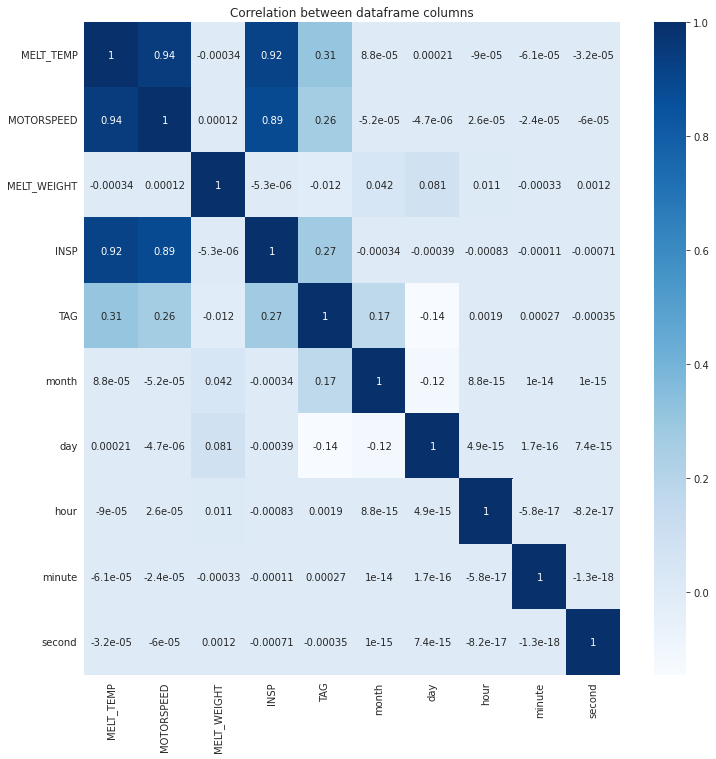

In [ ]:
# 상관관계 시각화
plt.figure(figsize=(12, 12))
plt.title('Correlation between dataframe columns')
sns.heatmap(df.corr(), annot=True, cmap='Blues')

## 2-4. 용해온도와 교반속도 시각화 및 전처리
- 3자리수로 되어있는 용해온도와 교반속도 칼럼 10으로 나눠줘서 소수점까지 표현

In [ ]:
# 용해온도 10으로 나눠줘서 교반속도와 온도를 제대로 표현
df['MOTORSPEED'] = df['MOTORSPEED']/10
df['MELT_TEMP'] = df['MELT_TEMP']/10
df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second
0,48.9,11.6,631,3.19,1.0,3,4,0,0,0
1,43.3,7.8,609,3.19,1.0,3,4,0,0,6
2,46.4,15.4,608,3.19,1.0,3,4,0,0,12
3,37.9,21.2,606,3.19,1.0,3,4,0,0,18
4,79.8,173.6,604,3.21,1.0,3,4,0,0,24


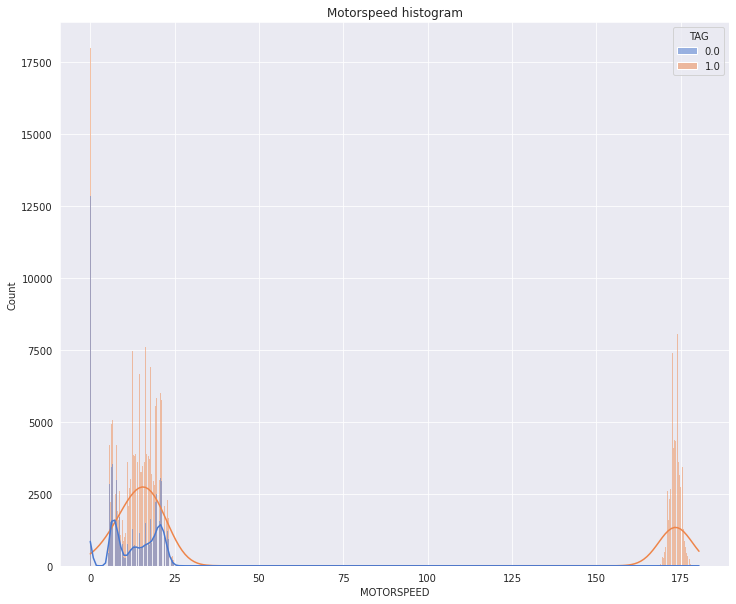

In [ ]:
# MOTORSPEED 시각화
plt.figure(figsize=(12,10))
plt.title('Motorspeed histogram')
sns.histplot(data=df, x='MOTORSPEED', kde=True, hue='TAG', binwidth=0.1, palette='muted')

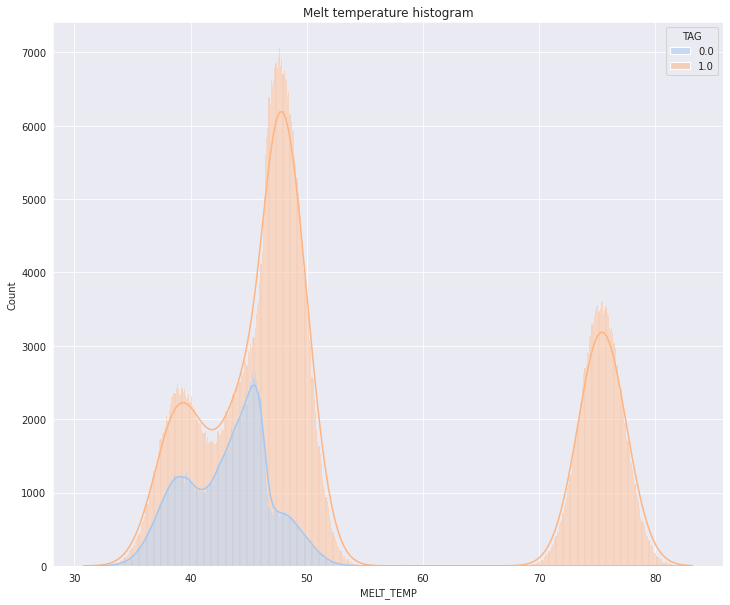

In [ ]:
# 용해온도 시각화
plt.figure(figsize=(12, 10))
plt.title('Melt temperature histogram')
sns.histplot(data=df, x='MELT_TEMP', kde=True, hue='TAG', binwidth=0.1, palette='pastel')

## 2-5. 용해탱크 내용량 시각화 및 전처리
- 용해탱크 내용량 에러 전처리 (3자리수 이하로 만들어주기)
  - 5자리수 데이터 중 6이하 100으로 나눠주기
  - 4자리수 데이터 중 6이하 10으로 나눠주기
  - 4자리수 데이터 중 7이상 앞자리 제거후 3자리수로 만들어주기
  - 3자리수 데이터 중 7이상 10으로 나눠주기

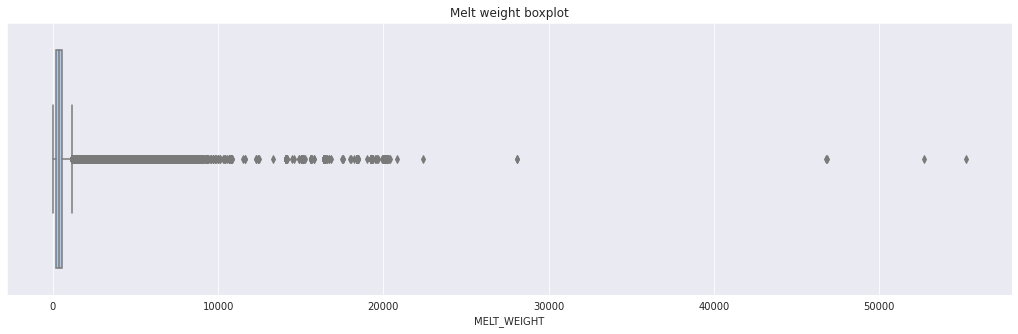

In [ ]:
# 용해탱크 내용량 전처리 전 내용량 boxplot을 통해 데이터 분포도 및 이상치 확인
# 이상치가 말도 안되게 많고 높음을 확인할 수 있었다.
plt.figure(figsize=(18,5))
plt.title('Melt weight boxplot')
sns.boxplot(data=df, x='MELT_WEIGHT', palette='pastel', color='tab:gray')

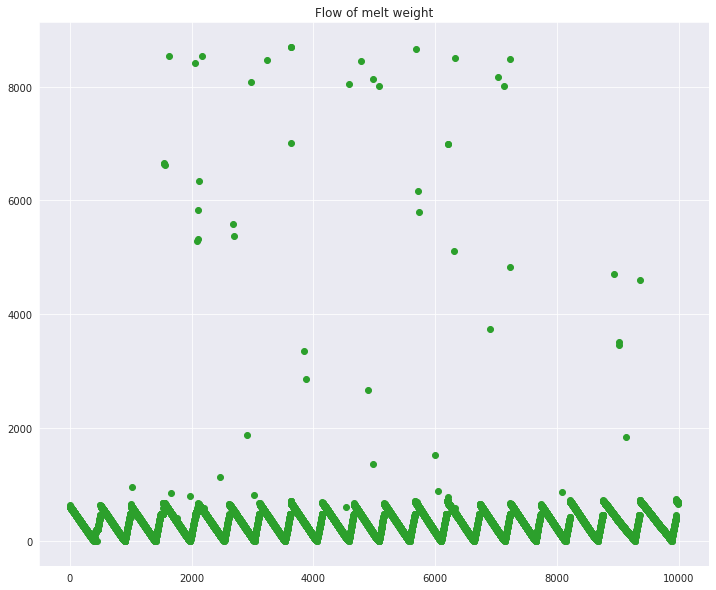

In [ ]:
# 용해탱크 내용량 사이클 1만번까지 확인
plt.figure(figsize=(12,10))
plt.title('Flow of melt weight')
series = df['MELT_WEIGHT'][:10000]
plt.scatter(np.arange(len(series)), series, color='tab:green')

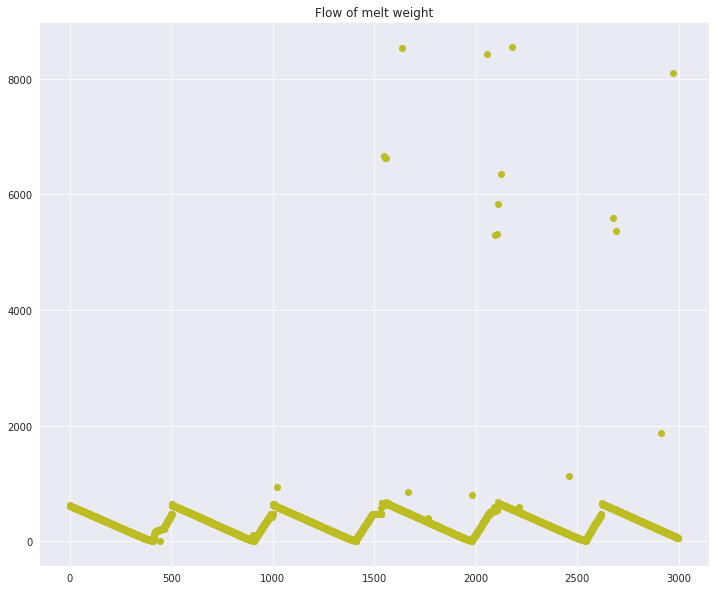

In [ ]:
# 확대하여 내용량 사이클 3천까지 확인
plt.figure(figsize=(12,10))
plt.title('Flow of melt weight')
series = df['MELT_WEIGHT'][:3000]
plt.scatter(np.arange(len(series)), series, color='tab:olive')

In [ ]:
# 용해탱크 내용량 가장 빈도수가 높은 수치 확인
df['MELT_WEIGHT'].mode()

0    688
dtype: int64

In [ ]:
# 내용량 5자리 수 통계수치 확인하여 최대치를 확인
df[df['MELT_WEIGHT'] > 10000].describe()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,50.915230,46.470115,17282.900862,3.195014,0.839080,3.487069,13.840517,9.883621,28.408046,27.646552
std,12.814974,63.985438,4297.468152,0.011543,0.367721,0.500192,7.861508,6.692374,17.121240,17.089062
min,34.800000,0.000000,10118.000000,3.180000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000
25%,43.000000,12.500000,15077.000000,3.190000,1.000000,3.000000,9.000000,6.000000,13.750000,12.000000
50%,47.000000,17.100000,18414.000000,3.190000,1.000000,3.000000,12.000000,9.000000,28.000000,30.000000
75%,50.000000,21.700000,20116.500000,3.200000,1.000000,4.000000,17.000000,13.000000,41.250000,42.000000
max,80.900000,177.300000,55252.000000,3.220000,1.000000,4.000000,31.000000,23.000000,59.000000,54.000000


In [ ]:
# 1) 첫번째 자리가 6이하인 5자리 수 > 3자리 수로 바꿔주기
df.loc[(9999 < df['MELT_WEIGHT']) & (df['MELT_WEIGHT']//10000 < 7), 'MELT_WEIGHT'] = df['MELT_WEIGHT']//100

In [ ]:
# 잘 바뀌어졌는지 확인
df[(9999 < df['MELT_WEIGHT']) & (df['MELT_WEIGHT']//10000 < 7)]

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second


In [ ]:
# 2) 첫번째 자리가 6이하인 4자리 수 > 3자리 수로 변경
df.loc[(999 < df['MELT_WEIGHT']) & (df['MELT_WEIGHT'] < 10000) & (df['MELT_WEIGHT']//1000 < 7), 'MELT_WEIGHT'] = df['MELT_WEIGHT']//10

In [ ]:
# 잘 바뀌었는지 데이터 확인
df[(999 < df['MELT_WEIGHT']) & (df['MELT_WEIGHT'] < 10000) & (df['MELT_WEIGHT']//1000 < 7)]

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second


In [ ]:
# 3) 4자리 수 데이터 중 앞자리 7이상, 앞자리 제거후 3자리 수로 만들어주기
df.loc[(999 < df['MELT_WEIGHT']) & (df['MELT_WEIGHT'] < 10000) & (df['MELT_WEIGHT']//1000 >= 7), 'MELT_WEIGHT'] = df['MELT_WEIGHT']%1000

In [ ]:
# 잘 바뀌어졌는지 확인
df[(999 < df['MELT_WEIGHT']) & (df['MELT_WEIGHT'] < 10000) & (df['MELT_WEIGHT']//1000 >= 7)]

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second


In [ ]:
# 4) 내용량이 688 초과인 3자리 수 > 2자리 수로 바꿔주기
df.loc[(df['MELT_WEIGHT'] < 1000) & (688 < df['MELT_WEIGHT']), 'MELT_WEIGHT'] = df['MELT_WEIGHT']//10

In [ ]:
# 잘 바뀌어졌는지 확인해 주기
df[(df['MELT_WEIGHT'] < 1000) & (688 < df['MELT_WEIGHT'])]

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG,month,day,hour,minute,second


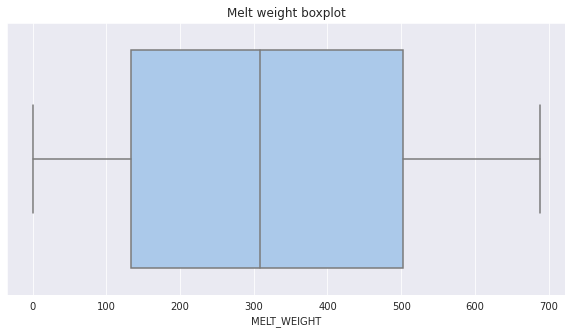

In [ ]:
# boxplot으로 재 시각화
plt.figure(figsize=(10,5))
plt.title('Melt weight boxplot')
sns.boxplot(data=df, x='MELT_WEIGHT', palette='pastel')

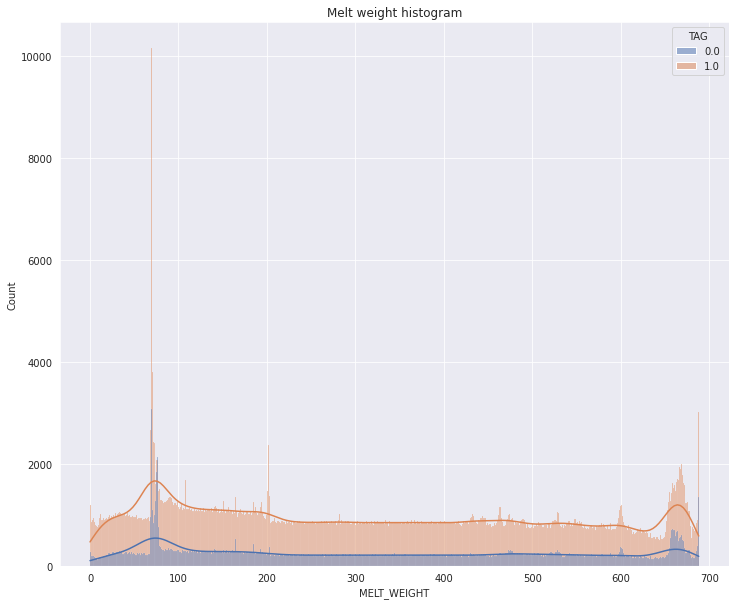

In [ ]:
# 용해탱크 내용량 시각화
plt.figure(figsize=(12,10))
plt.title('Melt weight histogram')
sns.histplot(data=df, x='MELT_WEIGHT', kde=True, hue='TAG', binwidth=1, palette='deep')

## 2-6. 전체 데이터 시각화
- 데이터 분포를 표현하기 위해 histrogram 및 pairplot을 사용

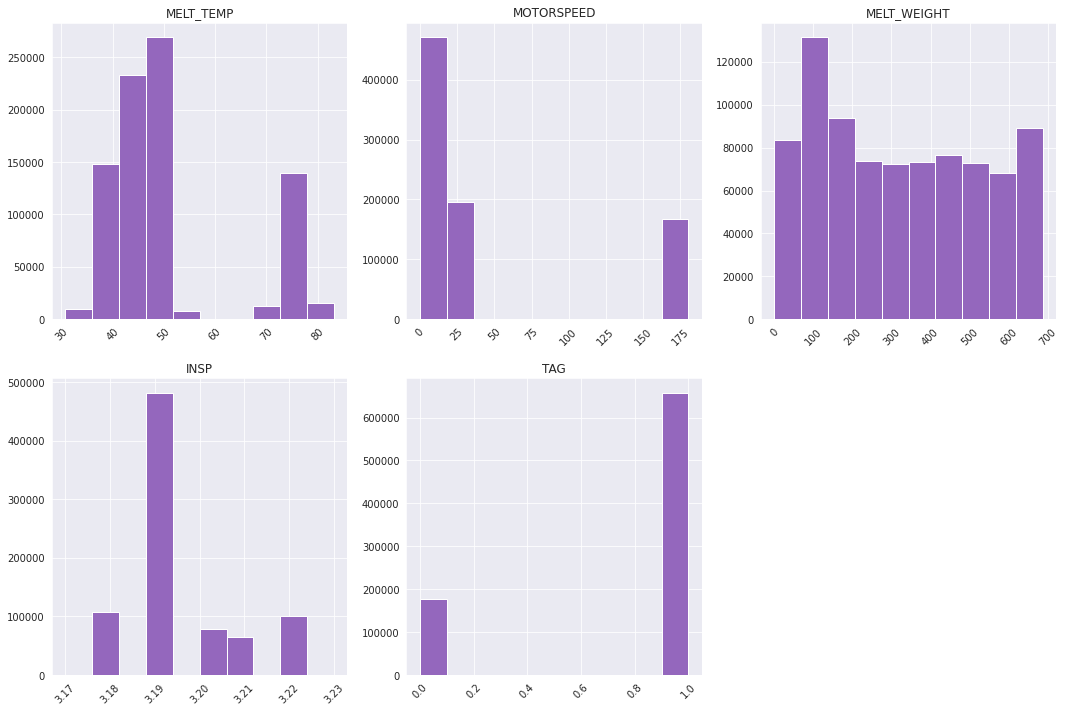

In [ ]:
# 전체 칼럼 한눈에 시각화
col_name = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']

plt.figure(figsize=(18, 12))
for i in range(len(col_name)):
  num = 231+i
  plt.subplot(num)
  plt.hist(df[col_name[i]], color='tab:purple')
  plt.xticks(rotation=45)
  plt.title(col_name[i])
plt.show()

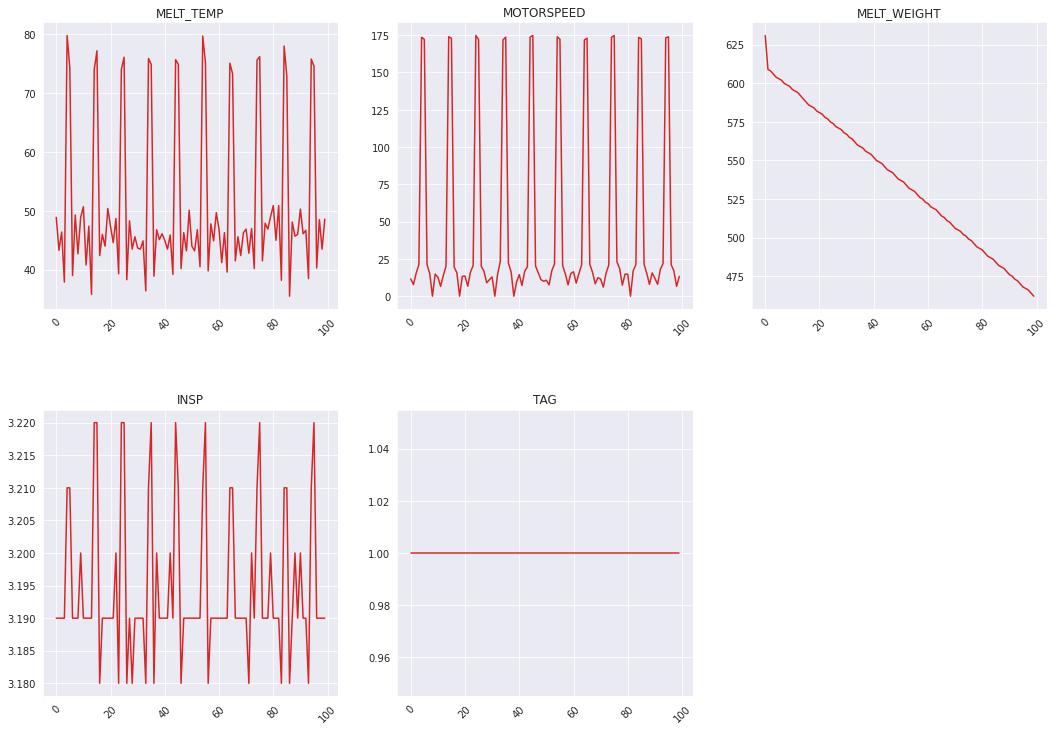

In [ ]:
# 각 칼럼별 데이터 흐름 100개씩 확인
plt.figure(figsize=(18,12))
for i in range(len(col_name)):
  num=231+i
  plt.subplot(num)
  plt.plot(df[col_name[i]][0:100], color='tab:red')
  plt.xticks(rotation=45)
  plt.title(col_name[i])
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, wspace=0.2, hspace=0.35)
plt.show()

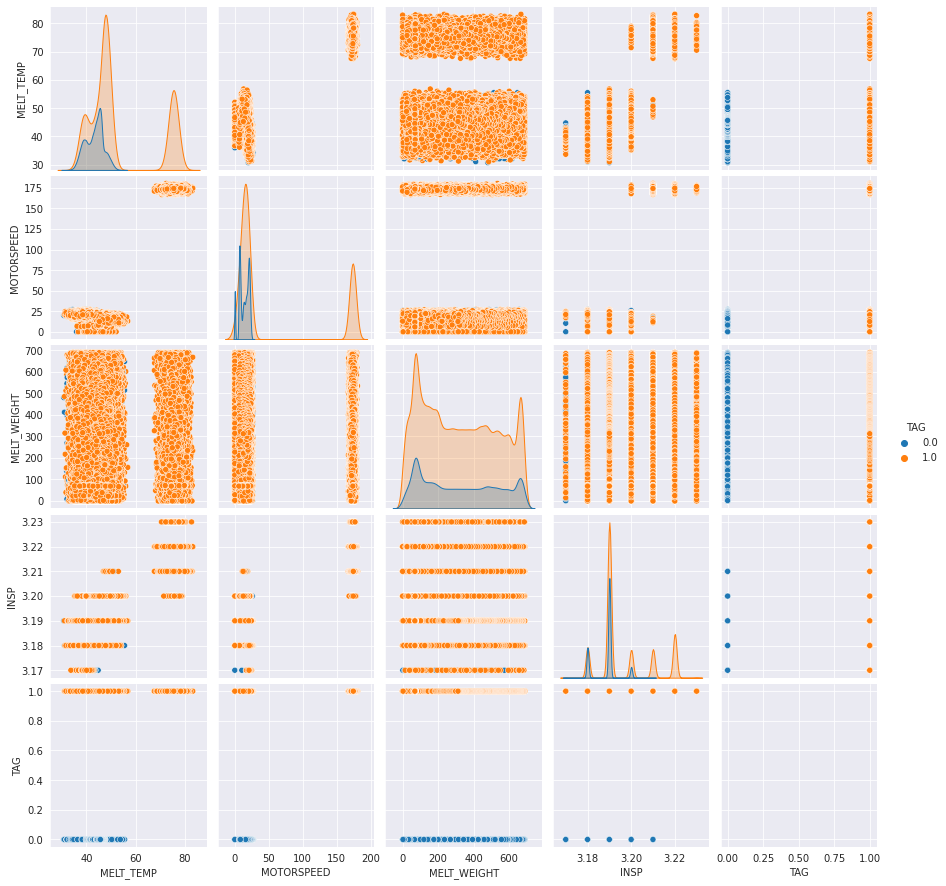

In [ ]:
# 각 칼럼별 한눈에 시각화 하기 위한 pariplot
sns.pairplot(data=df, hue='TAG', vars=['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG'])

## 2-7. 불량 데이터 분포 및 라벨 값 비율 시각화
- histogram으로 분포 시각화
- pie chart로 비율 시각화

In [ ]:
# 불량 데이터 월별 그룹화 및 월별 불량수 확인
ng3_df = df[(df['TAG']==0)&(df['month']==3)]
ng4_df = df[(df['TAG']==0)&(df['month']==4)]

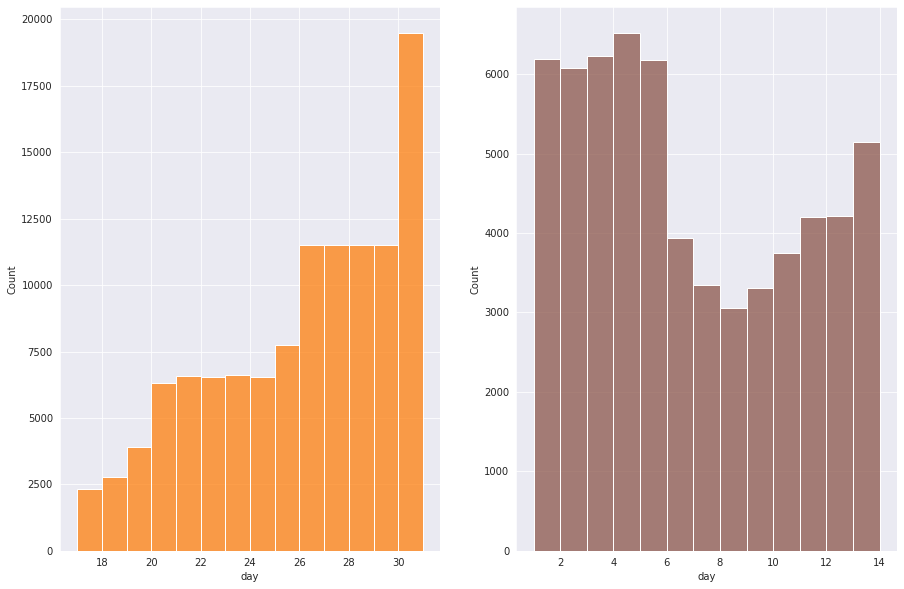

In [ ]:
# 불량품 월&일별 확인
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))

sns.histplot(data=ng3_df, x='day', ax=ax[0], binwidth=1, palette='pastel', color='tab:orange')
sns.histplot(data=ng4_df, x='day', ax=ax[1], binwidth=1, palette='pastel', color='tab:brown')

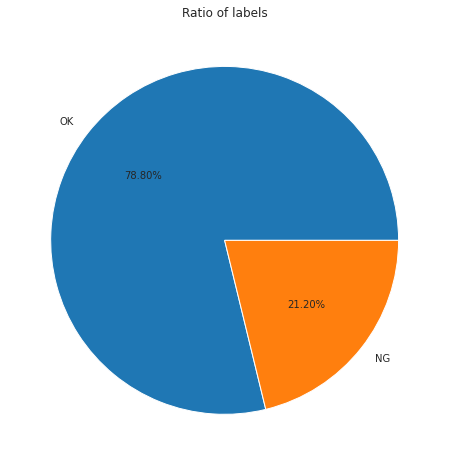

In [ ]:
# OK, NG 개수 비율 확인
plt.figure(figsize=(8,8))
plt.pie(df["TAG"].value_counts(), labels = ['OK', 'NG'], autopct="%2.2f%%")
plt.title('Ratio of labels')
plt.show()

## 2-8 수분함유량 시각화 및 전처리
- 이산적인 데이터로 표현 가능한 수분함유량을 one-hot-encoding을 사용하여 분류

Text(0.5, 1.0, 'INSP histogram')

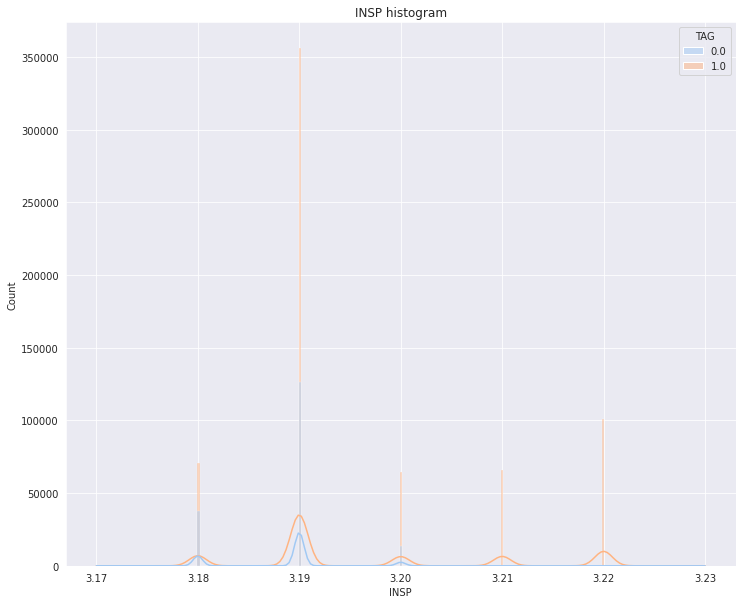

In [ ]:
plt.figure(figsize=(12,10))
sns.histplot(data=df, x='INSP', kde=True, hue='TAG', palette='pastel')
plt.title('INSP histogram')

In [ ]:
df = pd.get_dummies(data=df, columns=['INSP'])

## 2-9. 라벨 값 데이터셋에서 제거 후 새로운 변수에 할당
- 라벨 값은 정답으로 사용되기 때문에 다른 변수에 할당 후 데이터 셋에서 제거


In [ ]:
# label 데이터 y에 할당
y = df['TAG']

In [ ]:
# 라벨 컬럼 삭제
df = df.drop(columns = 'TAG')
df

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,month,day,hour,minute,second
0,48.9,11.6,631,3.19,3,4,0,0,0
1,43.3,7.8,609,3.19,3,4,0,0,6
2,46.4,15.4,608,3.19,3,4,0,0,12
3,37.9,21.2,606,3.19,3,4,0,0,18
4,79.8,173.6,604,3.21,3,4,0,0,24
...,...,...,...,...,...,...,...,...,...
835195,75.5,174.3,318,3.21,4,30,23,59,30
835196,38.5,20.6,317,3.19,4,30,23,59,36
835197,46.5,14.8,316,3.20,4,30,23,59,42
835198,46.7,0.0,314,3.19,4,30,23,59,48


## 2-10. Train/Test Data Split & Normalization
- 학습 데이터와 테스트 데이터 7:3 비율로 나누기
- MinMaxScaler()를 이용하여 각 데이터를 0-1사이 특정 범위로 변환

In [ ]:
# train과 test 데이터로 나눠주기 (7:3 비율로)
# 중간 데이터를 test 데이터로 나눠준 이유는 중간에 불량값이 많기 때문에 데이터 불균형이 사라짐
split_data = int(df.shape[0]*0.5)
split_data2 = int(df.shape[0]*0.8)
X_train_pre = df[:split_data]
X_train_post = df[split_data2:]
X_train = np.concatenate((df[:split_data], df[split_data2:]), axis=0)
X_test = df[split_data:split_data2]
y_train_pre = y[:split_data]
y_train_post = y[split_data2:]
y_train = np.concatenate((y[:split_data], y[split_data2:]), axis=0)
y_test = y[split_data:split_data2]
print(X_train.shape)
print(X_test.shape)

(584640, 9)
(250560, 9)


In [ ]:
# minmaxscaler를 이용해 normalization 진행
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 테스트 데이터에 라벨 값 확인
y_test.value_counts()

1.0    194609
0.0     55951
Name: TAG, dtype: int64

## 2-11. SMOTE 이용
- SMOTE를 이용하여 불균형 데이터의 값들을 맞춰주기

In [ ]:
smote = SMOTE(random_state=0)

In [ ]:
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트: ', X_train.shape,y_train.shape)
print('SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트: ', X_train_over.shape,y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트:  (584640, 9) (584640,)
SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트:  (927048, 9) (927048,)
SMOTE 적용 후 레이블 값 분포: 
 1.0    463524
0.0    463524
dtype: int64


In [ ]:
X_train_over = pd.DataFrame(X_train_over)
y_train_over = pd.DataFrame(y_train_over)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

## 2-12. 데이터셋 만들기
- 함수 정의 후, 순차적으로 10개의 데이터를 이용하여 다음 라벨 값을 예측

In [ ]:
def make_dataset(data, label, window_size):
  feature_list = []
  label_list = []
  for i in range(len(data) - window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list), np.array(label_list)

In [ ]:
train_feature, train_label = make_dataset(X_train_over, y_train_over, 10)
test_feature, test_label = make_dataset(X_test, y_test, 10)

## 2-13. 학습 데이터를 학습 데이터와 검증 데이터 나눠주기
- 8:2 비율로 학습 데이터를 나눠주어, 모델이 학습하는 동안 검증을 동시에 하여 과적합 방지

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)

# 3. 모델 설계, 학습 및 예측

## 3-1. 하이퍼 파라미터 지정
- 분석 모델 설계시 사람이 지정 가능한 하이퍼 파라미터를 변수에 할당하여 쉽게 접근 후 변경 가능

In [ ]:
units = 50
patience = 5
batch_size = 50
learning_rate = 0.001
beta_1 = 0.9

In [ ]:
adam = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = beta_1)

## 3-2. 모델 설계
- GRU를 3번 사용하여 모델 설계

In [ ]:
model = Sequential()
model.add(GRU(units,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='tanh',
               return_sequences=True)
         )
model.add(GRU(units,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='tanh',
               return_sequences=True)
         )
model.add(GRU(units,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='tanh',
               return_sequences=False)
         )
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=patience)
filename = '/content/drive/MyDrive/Next AI/final_tmp_checkpoint_1.h5'
checkpoint = ModelCheckpoint(filepath=filename, monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='auto')

## 3-3. 모델 학습 및 검증 데이터로 평가

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
12979/12979 [==============================] - 102s 7ms/step - loss: 0.0685 - accuracy: 0.9717 - val_loss: 0.0469 - val_accuracy: 0.9830
Epoch 2/200
12979/12979 [==============================] - 91s 7ms/step - loss: 0.0455 - accuracy: 0.9824 - val_loss: 0.0439 - val_accuracy: 0.9825
Epoch 3/200
12979/12979 [==============================] - 92s 7ms/step - loss: 0.0418 - accuracy: 0.9842 - val_loss: 0.0651 - val_accuracy: 0.9761
Epoch 4/200
12979/12979 [==============================] - 92s 7ms/step - loss: 0.0399 - accuracy: 0.9853 - val_loss: 0.0383 - val_accuracy: 0.9867
Epoch 5/200
12979/12979 [==============================] - 93s 7ms/step - loss: 0.0387 - accuracy: 0.9859 - val_loss: 0.0373 - val_accuracy: 0.9869
Epoch 6/200
12979/12979 [==============================] - 92s 7ms/step - loss: 0.0383 - accuracy: 0.9861 - val_loss: 0.0379 - val_accuracy: 0.9861
Epoch 7/200
12979/12979 [==============================] - 94s 7ms/step - loss: 0.0378 - accuracy: 0.9862 - val

## 3-4. 학습 된 모델 손실 및 정확도 지표 시각화

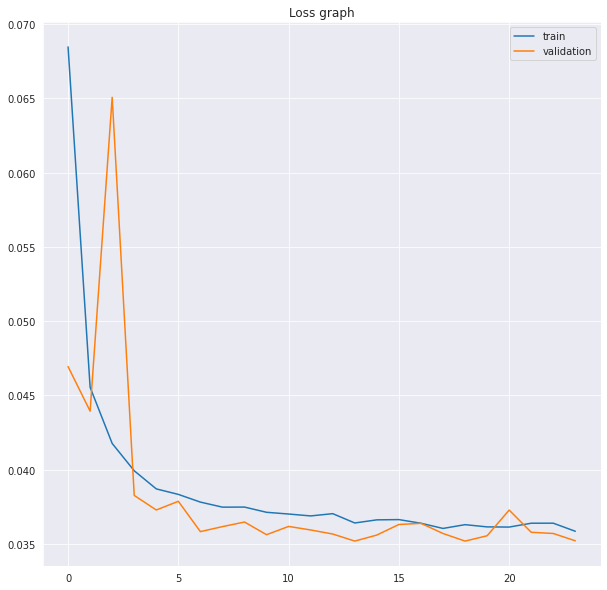

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss graph')
plt.legend()
plt.show()

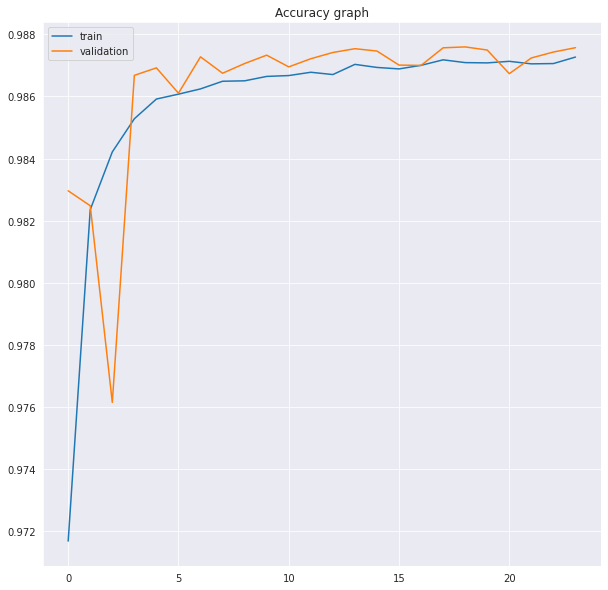

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy graph')
plt.legend()
plt.show()

## 3-5. 학습 된 모델로 테스트 데이터 예측

In [ ]:
model.load_weights(filename)

pred = model.predict(test_feature)

7830/7830 [==============================] - 21s 3ms/step


In [ ]:
pred_df = pd.DataFrame(pred, columns=['TAG'])

In [ ]:
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x>=0.5 else 0)

In [ ]:
pred_df['TAG'].value_counts()

1    190125
0     60425
Name: TAG, dtype: int64

# 4. 모델 평가 및 해석
- 다양한 평가지표를 이용하여 모델 성능 평가
  - Confusion matrix
  - F1-Score
  - ROC-AUC Score
  - ROC-AUC Curve

In [ ]:
classify = confusion_matrix(test_label, pred_df)
print(classify)

[[ 38185  17762]
 [ 22240 172363]]


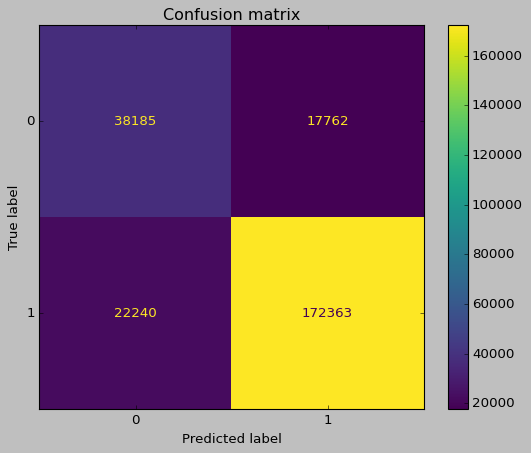

In [ ]:
ConfusionMatrixDisplay(classify).plot()
plt.title('Confusion matrix')
plt.style.use('ggplot')
plt.show()

In [ ]:
acc = accuracy_score(test_label, pred_df)
print("accuracy: %0.4f" %acc)
p = precision_score(test_label, pred_df)
print("precision: %0.4f" %p)
r = recall_score(test_label, pred_df)
print("recall: %0.4f" %r)
f1 = f1_score(test_label, pred_df)
print("f1-score: %0.4f" %f1)

accuracy: 0.8403
precision: 0.9066
recall: 0.8857
f1-score: 0.8960


In [ ]:
roc_auc_score(test_label, pred)

0.8709664684039422

In [ ]:
fpr, tpr, _ = roc_curve(test_label, pred)
roc_auc = auc(fpr, tpr)

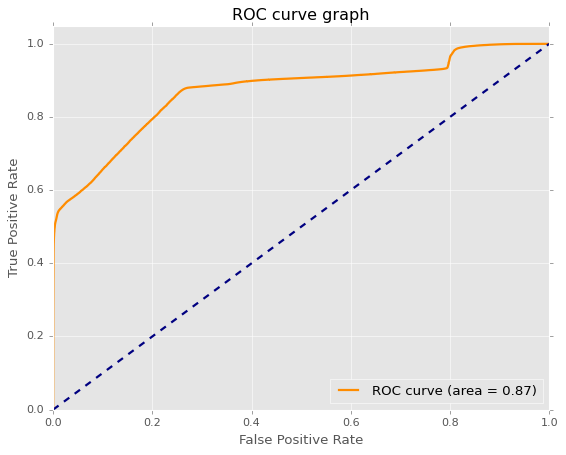

auc result:0.8709664684039422


In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve graph')
plt.legend(loc="lower right")
plt.show()
print(f"auc result:{roc_auc}")